In [1]:
from paddleocr import PaddleOCR
import re
from PIL import Image
import numpy as np

In [2]:
import oci
import cv2
from oci.ai_vision.models import AnalyzeImageDetails, ImageTextDetectionFeature, InlineImageDetails
import base64
from oci.config import validate_config

def analyze_img_oci(image_array):

    config = {
        'user': 'ocid1.user.oc1..aaaaaaaagmbp7qkvz4nd5ejwke64hy464ygkn6hkjrg4jqab3atkmglriyhq',
        'region': 'mx-queretaro-1',
        'tenancy': 'ocid1.tenancy.oc1..aaaaaaaafnp4ykozv2ffag4h3mmsefi7jihsx6sfxwuw3jsk42fmsb2jmiva',
        'key_file': '../../../a01656699@tec.mx_2024-11-11T23_34_55.242Z.pem',
        'fingerprint': 'e4:0b:a6:9a:be:08:47:56:f8:8a:bc:74:42:85:6f:87'
    }

    validate_config(config)

    ai_vision_client = oci.ai_vision.AIServiceVisionClient(config)

    _, buffer = cv2.imencode('.jpg', image_array)
    image_data = base64.b64encode(buffer).decode('utf-8')

    analyze_image_response = ai_vision_client.analyze_image(
        analyze_image_details=AnalyzeImageDetails(
            features=[
                ImageTextDetectionFeature(
                    feature_type="TEXT_DETECTION"
                )
            ],
            image=InlineImageDetails(
                data=image_data
            ),
            compartment_id="ocid1.tenancy.oc1..aaaaaaaafnp4ykozv2ffag4h3mmsefi7jihsx6sfxwuw3jsk42fmsb2jmiva"
        )
    )

    return analyze_image_response.data

In [3]:
import cv2
import numpy as np

def find_plates(np_image):
  img = np_image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
  edged = cv2.Canny(bfilter, 30, 200)
  contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

  location = None
  for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
      location = approx
      break

  if location is not None:
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)

    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2 + 1, y1:y2 + 1]

    return cropped_image
  else:
    return None

In [4]:
import easyocr

def read_text(np_image):
    img = np_image
    cropped = find_plates(img)
    _, thresh = cv2.threshold(cropped, 170, 255, cv2.THRESH_BINARY_INV)
    blurred = cv2.medianBlur(thresh, 1)
    display(Image.fromarray(blurred))
    reader = easyocr.Reader(['en'])
    result = reader.readtext(blurred)
    result.sort(key=lambda x: x[0][0][0])
    joined_text = ""
    for (bbox, text, prob) in result:
      text = re.sub(r'[^a-zA-Z0-9]', '', text)
      joined_text += text
    joined_text
    return joined_text

def compare_text(text, np_image):
    text = re.sub(r'[^a-zA-Z0-9]', '', text)
    read_text_result = read_text(np_image)
    print(read_text_result)
    if text == read_text_result:
        return True
    return False

In [5]:
def preprocessing(image_array):
    img = image_array
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY_INV)
    blurred = cv2.medianBlur(thresh, 1)
    return blurred

def get_text_list_oci(img_arr):
    #processed = preprocessing(img_arr)
    analysis = analyze_img_oci(img_arr)
    texts = []
    for line in analysis.image_text.lines:
        text = line.text
        text = re.sub(r'[^a-zA-Z0-9]', '', text)
        texts.append(text)
    return texts

def is_text_present_oci(img_arr, text):
    text = re.sub(r'[^a-zA-Z0-9]', '', text)
    texts = get_text_list_oci(img_arr)
    print(texts)
    if text in texts:
        return True
    return False

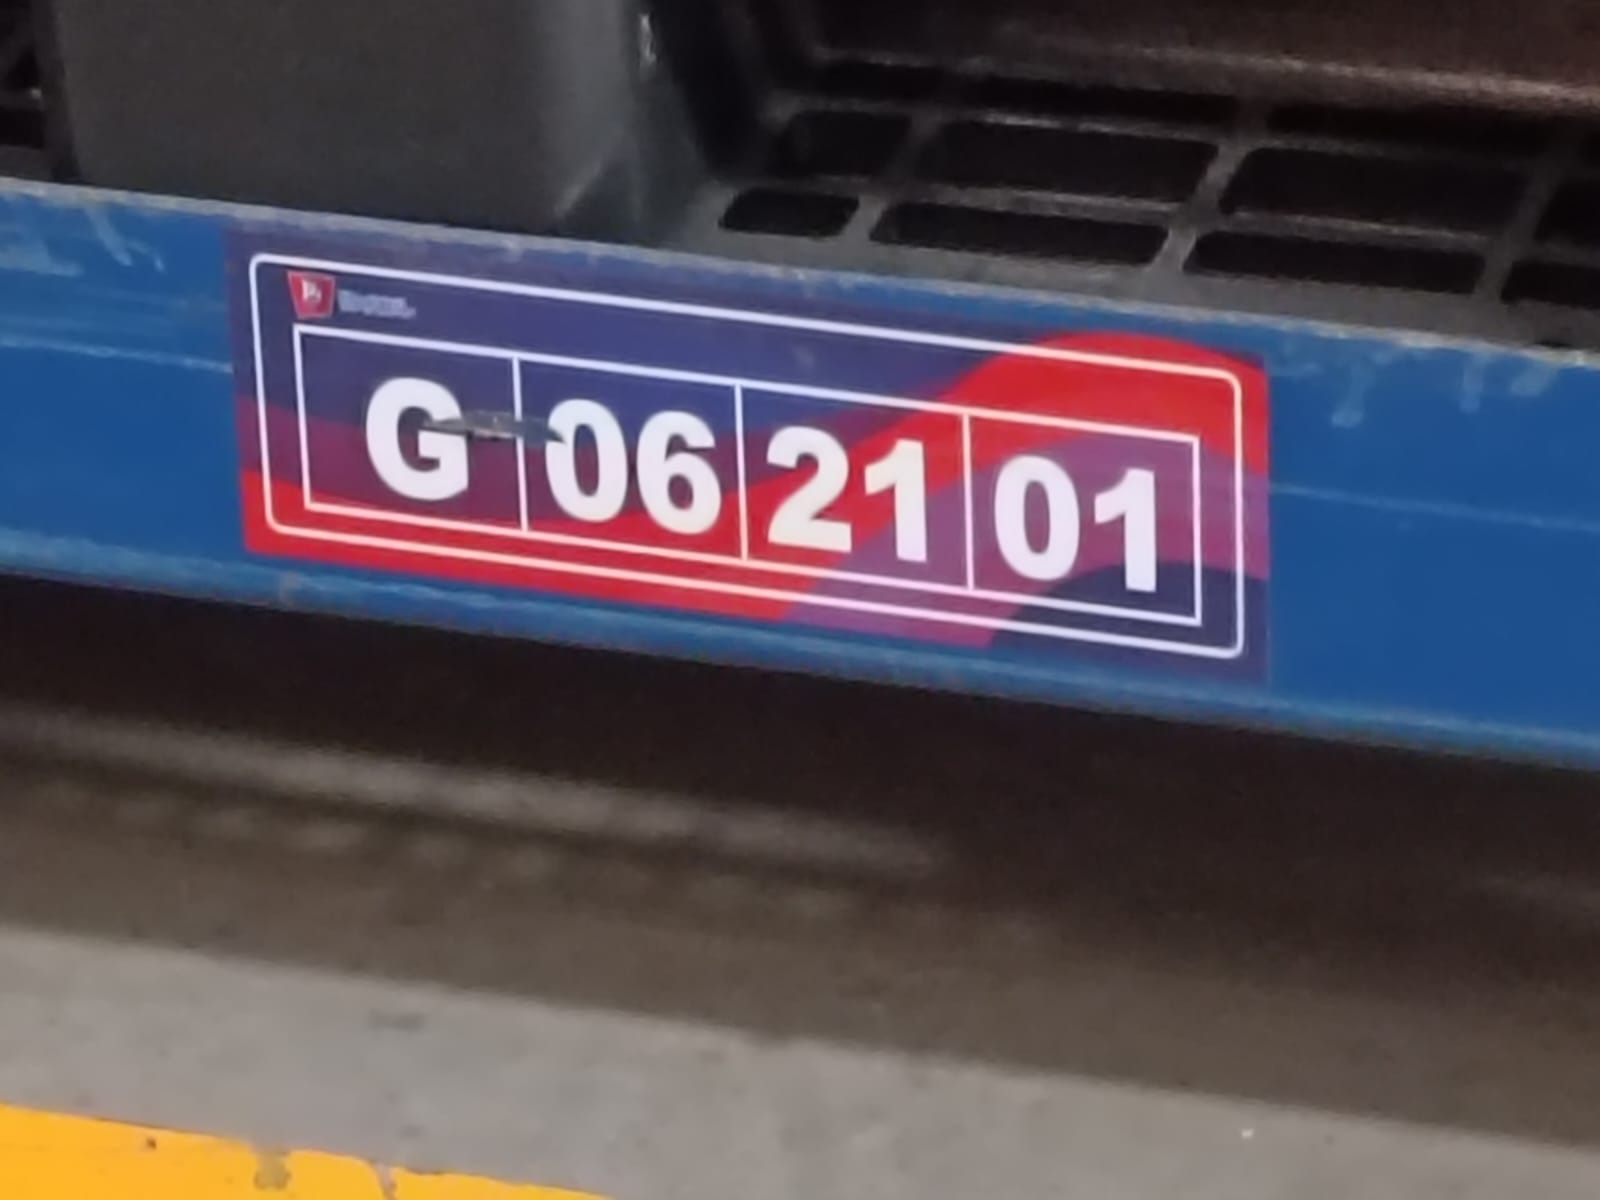

In [6]:
image_path = '/Users/meister/Desktop/RetoBimbo/Utils/Fotos/IMG-20241105-WA0083.jpg'
img = Image.open(image_path)
display(img)

In [7]:
numpy_image = np.array(img)

is_text_present_oci(img_arr=numpy_image, text='F062301')

['G062101']


False

In [ ]:
from flask import Flask, request, jsonify
from PIL import Image
from flask_cors import CORS
import io

app = Flask(__name__)
CORS(app)

@app.route('/check_image', methods=['POST'])
def upload_file():

    text = request.form.get('text')
    image_file = request.files.get('image')
    
    if image_file:
        image = Image.open(io.BytesIO(image_file.read()))
        np_img = np.array(image)
        isEqual = is_text_present_oci(img_arr=np_img, text=text)
        response = {
            'isEqual': isEqual
        }
    else:
        response = {
            'error': 'No se recibió ninguna imagen'
        }
    
    print(response)
    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=False, port=8080)

 * Serving Flask app '__main__'
 * Debug mode: off


[2024-11-12 18:42:57,354] [    INFO] _internal.py:97 - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8080
[2024-11-12 18:42:57,354] [    INFO] _internal.py:97 - Press CTRL+C to quit
[2024-11-12 18:44:38,174] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:44:38] "POST /check_image HTTP/1.1" 200 -


['G062501']
{'isEqual': False}


[2024-11-12 18:44:43,461] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:44:43] "POST /check_image HTTP/1.1" 200 -


['G062501']
{'isEqual': False}


[2024-11-12 18:45:50,842] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:45:50] "POST /check_image HTTP/1.1" 200 -


['G062501']
{'isEqual': True}


[2024-11-12 18:45:54,169] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:45:54] "POST /check_image HTTP/1.1" 200 -


['F062801']
{'isEqual': True}


[2024-11-12 18:46:15,310] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:46:15] "POST /check_image HTTP/1.1" 200 -


['F062801']
{'isEqual': False}


[2024-11-12 18:46:19,202] [    INFO] _internal.py:97 - 127.0.0.1 - - [12/Nov/2024 18:46:19] "POST /check_image HTTP/1.1" 200 -


['G062302']
{'isEqual': True}
